In [ ]:
from humpback import *
from datetime import datetime

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
def create_previous_data_df(df, num_points):
    data_lists = []

    for i in range(len(df)):
        if i < num_points:
            continue
        
        prev_data = [df.iloc[i-n, 0] if i >= n else None for n in range(1, num_points+1)]
        data_lists.append(prev_data)

    columns = [f"X_{n}" for n in range(1, num_points+1)]
    prev_df = pd.DataFrame(data_lists, columns=columns)

    return prev_df

In [ ]:
client = connectBinanceAPI()

In [ ]:
symbol = 'BTCUSDT'
interval = '1h'
window = 60

start_str = int(datetime(2020,1,1,0,0).timestamp() * 1000)
end_str   = int(datetime(2021,12,31,0,0).timestamp() * 1000)

In [ ]:
data = getBinanceData(client=client,
                      symbol=symbol,
                      interval=interval,
                      start_str=start_str,
                      end_str=end_str)

In [ ]:
scaler, scaled_data = transformData(data[['Close']])

In [ ]:
data_train = pd.DataFrame(scaled_data.iloc[:int(data.shape[0]*0.6)])
data_test  = pd.DataFrame(scaled_data.iloc[int(data.shape[0]*0.6):])

In [ ]:
X_train = create_previous_data_df(data_train, window)
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

y_train = data_train.iloc[window:]
y_train = np.array(y_train)

In [ ]:
X_test = create_previous_data_df(data_test, window)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_test = data_test.iloc[window:]
y_test = np.array(y_test)

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units=50,
                   return_sequences=True,
                   input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,
                   return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,
                   return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

In [ ]:
regressor.compile(optimizer='adam',
                  loss='mean_squared_error')
regressor.fit(X_train, y_train,
              epochs=10,
              batch_size=32)

In [17]:
predicted = regressor.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


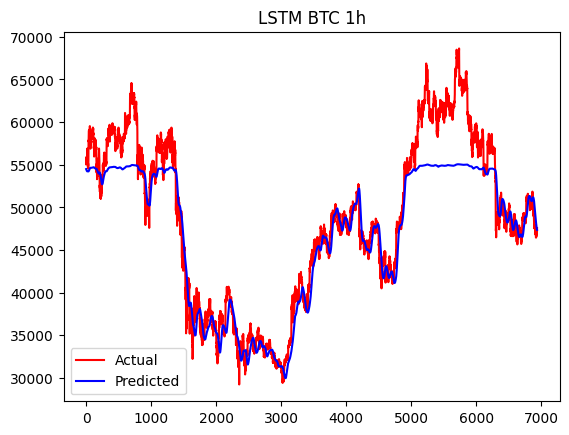

In [18]:
plt.plot(y_test, color='red', label='Actual')
plt.plot(predicted, color='blue', label='Predicted')
plt.title('LSTM BTC 1h')
plt.legend() 